In [1]:
import pandas as pd
import numpy as np
from pymol import cmd
import itertools
from matplotlib import pyplot as plt
import os
import warnings
from pymol import stored
import multiprocessing
import cv2
import mdtraj as md
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
import time
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        print("{} took {} seconds".format(
        self.name, time.time() - self.t))

In [88]:
def save_pocket(pdb, sdf, name):
    cmd.reinitialize()
    cmd.load(pdb)
    cmd.load(sdf, "LIG")
    cmd.select("POCK","br. LIG around 4")
    stored.idx = 0
    cmd.iterate("POCK and n. CA", expression="stored.idx+=1")
    cmd.save(name, "POCK")
    return stored.idx

In [89]:
def split_sdf(filename):
    split = []
    with open(filename,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            split.append("".join(list(group)))
    num_files = (int)(np.ceil(len(split)/10000))
    print(num_files)
    for i in range(num_files):
        f =  open("tmp{0}.sdf".format(i), 'w+')
        if i+10000 >= len(split):
            f.write("$$$$\n".join(split[i:]))
        else:
            f.write("$$$$\n".join(split[i:i+10000]))

In [90]:
apo_pdb = "ADRP_6W02_A_1_H.pdb"
sdf = "adrp_adpr_A_cat_sorted.sdf"

In [91]:
#split_sdf(sdf)
#pock_pdb = "gen_pocket_adrp.pdb"
#num_residues = save_pocket(apo_pdb, sdf, pock_pdb) 

In [92]:
pock_pdb = "adrp_pocket.pdb"
def maker(data, tmp_file=None):
    i,_ = data
    if tmp_file is None:
        tmp_file = str(id(multiprocessing.current_process()))
    cmd.load(pock_pdb, 'pdb', i+1)    
    stored.idx = 0
    cmd.iterate("pdb and n. CA", expression="stored.idx+=1")
    num_residues = stored.idx
    
    cmd.save("test_sdf_load{}.pdb".format(tmp_file), 'not resn EDO and not resn ACE and not resn NME', i + 1)
    with open("test_sdf_load{}.pdb".format(tmp_file), 'r') as f:
        filn = f.read().split("\n")
    lines = []
    for i,line in enumerate(filn):
        if "UNK" in line:
            if i < 10:
                line = line.replace("UNK", "UN{}".format(i))
            elif i < 100:
                line = line.replace("UNK", "U{}".format(i))
            else:
                assert(False)
        lines.append(line)
    with open("test_sdf_load{}.pdb".format(tmp_file), 'w') as f:
        f.write("\n".join(lines))
    
    ## Load in PDB make contact map
    t = md.load("test_sdf_load{}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    matrix, l = md.compute_contacts(t, contacts=pairs, scheme="closest-heavy")
    matrix = np.array(matrix).reshape((pl,pl))
    p_contact_matrix = matrix
    
    ##
    mask = np.zeros((pl, pl, 1))
    
    ### generate protein-ligand mask
    for i in range(pl - num_residues, pl):
        for j in range(pl - num_residues, pl):
            mask[i,j] = 1
            mask[j,i] = 1
    for i in range(pl - num_residues):
        for j in range( pl - num_residues):
            mask[i,j] = -1
            mask[j,i] = -1
    p_img = cv2.resize(matrix, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1) 
    m_img = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1) 
    p_contact_matrix = np.concatenate([p_img, m_img], axis=-1)
    os.remove("test_sdf_load{}.pdb".format(tmp_file))
    return p_contact_matrix.astype(np.float32)

In [93]:
def run_sim_multiprocess(i):
    with multiprocessing.Pool(16) as p:
        sdf = "tmp{0}.sdf".format(i)
        print("reading sdf")
        print(i)
        cmd.reinitialize()
        cmd.load(sdf, "OBJ0")
        cmd.do("remove hydrogens")
        num_states = cmd.count_states()
        data = list(zip(range(num_states), range(num_states)))
        itern = p.imap(maker, data)
        for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
            maps.append(p_contact_matrix)
    

In [94]:
def run_sim(filename, progress=False):
    if progress:
        print("reading sdf")
    cmd.reinitialize()
    cmd.load(filename, "OBJ0")
    if progress:
        print("loaded sdf")
    cmd.do("remove hydrogens")
    num_states = cmd.count_states()
    data = list(zip(range(num_states), range(num_states)))
    if progress:
        print("running maker")
    for i in range(num_states):
        p_contact_matrix = maker(data[i])
        maps.append(p_contact_matrix)
        if progress and (i+1) % 100 == 0:
            print(i+1)
    if progress:
        print("done")

In [95]:
import itertools
def run_sim_string(f):
    s, pdb_list = stringify("tmp{0}.sdf".format(f), "adrp_pocket.pdb")
    with multiprocessing.Pool(32) as p:
        num_states = len(s)
        data = list(zip(range(num_states), s))
        itern = p.imap(maker_w_strings, data)
        for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
            maps.append(p_contact_matrix)


In [96]:
scores = "adrp_adpr_A_cat_sorted.csv"
scores = pd.read_csv(scores)

In [12]:
maps=[]
for i in np.arange(1):
    run_sim_multiprocess(i)
maps_mult_tmp = maps    

reading sdf
0
 PyMOL not running, entering library mode (experimental)


  0%|          | 0/10000 [00:00<?, ?it/s]

 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)
 PyMOL not running, entering library mode (experimental)


100%|██████████| 10000/10000 [00:37<00:00, 265.74it/s]


In [97]:
def stringify(sdf, pdb):
    sdf_split = []
    with open(sdf,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            sdf_split.append("".join(list(group)))
    with open(pdb,'r') as f:
        pdb_string = f.readlines()
    return sdf_split, pdb_string

In [98]:
def create_pdb(sdf, pdb_string,i):
    lines = sdf.split('\n')
    num_lines = (int)(lines[3].split(' ')[1])
    lig = lines[4:4+num_lines-1]
    lig = list(filter(lambda x: 'H' not in x, lig))
    lig_pdb = list(map(create_line, lig, np.arange(1,len(lig)+1)))
    f =  open("tmp{0}.pdb".format(i), 'w+')
    f.write("\n".join(lig_pdb))
    f.write("\n")
    f.write("".join(pdb_string))
    f.close()
    
def create_line(line,i):
    split = line.split(' ')
    split = list(filter(lambda x: x != '', split))
    atom = split[3]
    vals1 = (float)(split[0])
    vals2 = (float)(split[1])
    vals3= (float)(split[2]) 
    if i >=10 :
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"U"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    else:
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"UN"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    return new_string

In [165]:
def maker_w_strings(data):
    i,sdf_state = data
    tmp_file = str(id(multiprocessing.current_process()))
    create_pdb(sdf_state,pdb_list,tmp_file)
    t = md.load("tmp{0}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    matrix, l = md.compute_contacts(t, contacts=pairs, scheme="closest-heavy")
    matrix = np.array(matrix).reshape((pl,pl))
    p_contact_matrix = matrix
    
    # TODO hardcoded
    num_residues=26
    
    mask = np.zeros((pl, pl, 1))    
    ### generate protein-ligand mask
    for i in range(pl - num_residues, pl):
        for j in range(pl - num_residues, pl):
            # ligand
            mask[i,j] = 1
            mask[j,i] = 1
    for i in range(pl - num_residues):
        for j in range( pl - num_residues):
            # protein
            mask[i,j] = -1
            mask[j,i] = -1
            
    charge = np.zeros((pl,pl,1))
    c = get_charges(t)
    for i in range(pl):
        for j in range(pl):
            charge[i][j] = (c[i]+c[j])/2
            
    p_img = cv2.resize(matrix, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1) 
    m_img = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1) 
    c_img = cv2.resize(charge, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1) 
    
    p_contact_matrix = np.concatenate([p_img, m_img, c_img], axis=-1)
    os.remove("tmp{0}.pdb".format(tmp_file))
    return p_contact_matrix.astype(np.float32)

In [170]:
def get_charges(t):
    # create dictionary of charges
    dict_element = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}
    dict_aa = {"ASP": -1, "GLU":-1, "LYS":+1, "ARG":+1, "HIS":+1}
    charges=[]
    # iterate through all ligand residues and assign charge
    for r in list(t.topology.atoms):
        if str(r).startswith('U'):
            charges.append(dict_element[r.name])
    # iterate through all protein residues and assign charge
    for r in list(t.topology.residues):
        if not str(r).startswith('U'):
            if r.name in dict_aa:
                charges.append(dict_aa[r.name])
            else:
                charges.append(0)
    return charges            

In [175]:
import itertools
maps=[]
for f in range(10):
    s, pdb_list = stringify("tmp{0}.sdf".format(f), "adrp_pocket.pdb")
    with multiprocessing.Pool(32) as p:
        num_states = len(s)
        data = list(zip(range(num_states), s))
        itern = p.imap(maker_w_strings, data)
        for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
            maps.append(p_contact_matrix)
maps_string_tmp=maps            


100%|██████████| 10000/10000 [01:37<00:00, 102.47it/s]


In [176]:
print(len(maps))

100000


In [177]:
f = open("data_wcharge_100k.pkl","wb")
pickle.dump(maps,f)

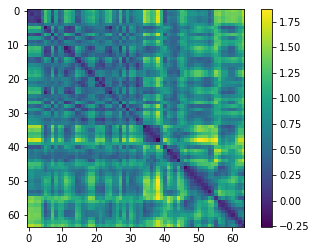

In [163]:
plt.imshow(maps[0][:,:,0])
plt.colorbar()

In [17]:
maps=[]
for f in range(1):
    s, pdb_list = stringify("adrp_adpr_A_cat_sorted_top10000.sdf", "adrp_pocket.pdb")
    with multiprocessing.Pool(32) as p:
        num_states = len(s)
        data = list(zip(range(num_states), s))
        itern = p.imap(maker_w_strings, data)
        for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
            maps.append(p_contact_matrix)
maps_string_top=maps 

100%|██████████| 10000/10000 [00:43<00:00, 231.59it/s]


In [61]:
scores_sub = "adrp_adpr_A_cat_sorted_top100.csv"
scores_sub = pd.read_csv(scores_sub)

In [62]:
maps=[]
run_sim("adrp_adpr_A_cat_sorted_top100.sdf", progress=True)
maps_100_baseline=maps

reading sdf
loaded sdf
running maker
100
done


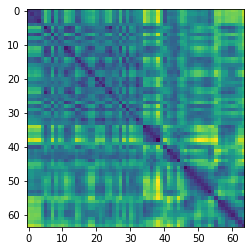

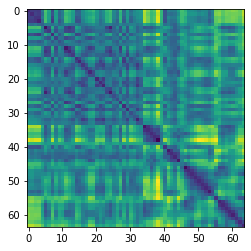

In [34]:
plt.imshow(maps_string_top[0][:,:,0])
plt.show()
plt.imshow(maps_100_baseline[0][:,:,0])

In [25]:
# compare scores
print(scores['Chemgauss4'].iloc[0:100].to_numpy()-scores_sub['Chemgauss4'].to_numpy())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [42]:
diff=[]
for i in range(100):
    diff.append(np.max(maps_100_baseline[i][:,:,0] - maps_string_top[i][:,:,0]))
print(np.max(diff))    

0.00018799305


In [63]:
import pickle
arr = pickle.load(open("data_large_fixed.pkl",'rb'))

In [64]:
diff=[]
for i in range(100):
    diff.append(np.max(maps_100_baseline[i][:,:,1] - arr[0][i][:,:,1]))
print(np.max(diff)) 

0.0


In [147]:
t = md.load("tmp140052712638416.pdb")
charges = get_charges(t)

In [148]:
print(charges)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -3, -3, -3, -3, -3, -3, -2, -2, -2, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]
